In [3]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load insurance data
df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='\t')

# Basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nData Types:")
print(df.dtypes.value_counts())

Dataset Shape: (1000098, 1)

Columns: ['UnderwrittenCoverID|PolicyID|TransactionMonth|IsVATRegistered|Citizenship|LegalType|Title|Language|Bank|AccountType|MaritalStatus|Gender|Country|Province|PostalCode|MainCrestaZone|SubCrestaZone|ItemType|mmcode|VehicleType|RegistrationYear|make|Model|Cylinders|cubiccapacity|kilowatts|bodytype|NumberOfDoors|VehicleIntroDate|CustomValueEstimate|AlarmImmobiliser|TrackingDevice|CapitalOutstanding|NewVehicle|WrittenOff|Rebuilt|Converted|CrossBorder|NumberOfVehiclesInFleet|SumInsured|TermFrequency|CalculatedPremiumPerTerm|ExcessSelected|CoverCategory|CoverType|CoverGroup|Section|Product|StatutoryClass|StatutoryRiskType|TotalPremium|TotalClaims']

Data Types:
object    1
Name: count, dtype: int64


In [2]:
# Try tab-separated first (common for .txt)
try:
    df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='\t')
    print("✅ Loaded as TAB-separated file")
except:
    # Fallback to comma-separated
    df = pd.read_csv('../data/MachineLearningRating_v3.txt')
    print("✅ Loaded as CSV file")

# Basic info
print("Dataset Shape:", df.shape)
print("\nFirst 3 rows:")
print(df.head(3))

NameError: name 'pd' is not defined

In [7]:
required_cols = ['TotalPremium', 'TotalClaims', 'Province', 'Gender', 'Make']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print("⚠️ Missing columns:", missing_cols)
else:
    print("✅ All required columns present!")

⚠️ Missing columns: ['TotalPremium', 'TotalClaims', 'Province', 'Gender', 'Make']


In [8]:
# Required columns from Week 3 PDF
required_cols = ['TotalPremium', 'TotalClaims', 'Province', 'Gender', 'Make']

# Check which are present
present_cols = [col for col in required_cols if col in df.columns]
missing_cols = [col for col in required_cols if col not in df.columns]

print("✅ Present columns:", present_cols)
if missing_cols:
    print("⚠️ Missing columns:", missing_cols)
    # Try common alternative names
    alt_names = {
        'TotalPremium': ['total_premium', 'Premium'],
        'TotalClaims': ['total_claims', 'Claims'],
        'Province': ['province', 'Region'],
        'Gender': ['gender', 'Sex'],
        'Make': ['make', 'CarMake']
    }
    for col in missing_cols:
        for alt in alt_names.get(col, []):
            if alt in df.columns:
                df.rename(columns={alt: col}, inplace=True)
                print(f"✅ Found '{alt}' → renamed to '{col}'")
                break

✅ Present columns: []
⚠️ Missing columns: ['TotalPremium', 'TotalClaims', 'Province', 'Gender', 'Make']


In [13]:
# Descriptive stats for financial columns (robust to missing cols)
financial_cols = ['TotalPremium', 'TotalClaims']
try:
    present_financial = [c for c in financial_cols if c in df.columns]
    print("Descriptive Statistics (Financial Columns):")
    if present_financial:
        print(df[present_financial].describe())
    else:
        print("⚠️ None of the expected financial columns found. Available columns:", list(df.columns))
except NameError:
    print("Error: DataFrame `df` not defined. Run the data-loading cells first.")

# Data types check (Section 4.a.ii) - only for required columns that exist
try:
    present_required = [c for c in required_cols if c in df.columns]
    if present_required:
        print("\nData Types:")
        print(df[present_required].dtypes)
    else:
        print("\n⚠️ None of the required columns are present. Available columns:", list(df.columns))
except NameError:
    pass

Descriptive Statistics (Financial Columns):
⚠️ None of the expected financial columns found. Available columns: ['UnderwrittenCoverID|PolicyID|TransactionMonth|IsVATRegistered|Citizenship|LegalType|Title|Language|Bank|AccountType|MaritalStatus|Gender|Country|Province|PostalCode|MainCrestaZone|SubCrestaZone|ItemType|mmcode|VehicleType|RegistrationYear|make|Model|Cylinders|cubiccapacity|kilowatts|bodytype|NumberOfDoors|VehicleIntroDate|CustomValueEstimate|AlarmImmobiliser|TrackingDevice|CapitalOutstanding|NewVehicle|WrittenOff|Rebuilt|Converted|CrossBorder|NumberOfVehiclesInFleet|SumInsured|TermFrequency|CalculatedPremiumPerTerm|ExcessSelected|CoverCategory|CoverType|CoverGroup|Section|Product|StatutoryClass|StatutoryRiskType|TotalPremium|TotalClaims']

⚠️ None of the required columns are present. Available columns: ['UnderwrittenCoverID|PolicyID|TransactionMonth|IsVATRegistered|Citizenship|LegalType|Title|Language|Bank|AccountType|MaritalStatus|Gender|Country|Province|PostalCode|MainCre

In [4]:
# Missing values (Section 4.b.i)
try:
    # Handle case where the file was read into a single pipe-concatenated column
    if len(df.columns) == 1 and '|' in df.columns[0]:
        raw_header = df.columns[0].split('|')
        df = df.iloc[:,0].str.split('|', expand=True)
        df.columns = raw_header
        print("Detected single pipe-concatenated column; split into columns.")

    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
    print("Top 10 Missing Columns:")
    non_zero = missing_df[missing_df['Missing %'] > 0].sort_values('Missing %', ascending=False).head(10)
    if not non_zero.empty:
        print(non_zero)
    else:
        print("No missing values detected.")
except NameError:
    print("Error: DataFrame `df` not defined. Run the data-loading cells first.")

# Outliers in TotalClaims (Section 4.f.i) - robust to missing or non-numeric columns
try:
    # Try to normalize possible alternative column names
    if 'TotalClaims' not in df.columns:
        for alt in ['total_claims', 'Claims', 'Total_Claims', 'Total Claims', 'Totalclaims']:
            if alt in df.columns:
                df.rename(columns={alt: 'TotalClaims'}, inplace=True)
                print(f"Renamed column '{alt}' to 'TotalClaims' for analysis.")
                break
    if 'TotalClaims' in df.columns:
        # ensure numeric values for outlier detection
        df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce')
        if df['TotalClaims'].dropna().empty:
            print("No numeric TotalClaims values available for outlier detection.")
        else:
            Q1 = df['TotalClaims'].quantile(0.25)
            Q3 = df['TotalClaims'].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df['TotalClaims'] < (Q1 - 1.5 * IQR)) | (df['TotalClaims'] > (Q3 + 1.5 * IQR))]
            print(f"\nOutliers in TotalClaims: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    else:
        print("Column 'TotalClaims' not found; skipping outlier detection.")
except NameError:
    pass

Detected single pipe-concatenated column; split into columns.
Top 10 Missing Columns:
No missing values detected.

Outliers in TotalClaims: 2793 (0.28%)

Outliers in TotalClaims: 2793 (0.28%)


In [5]:
# Descriptive stats for financial columns (robust to missing cols)
financial_cols = ['TotalPremium', 'TotalClaims']
try:
    present_financial = [c for c in financial_cols if c in df.columns]
    print("Descriptive Statistics (Financial Columns):")
    if present_financial:
        print(df[present_financial].describe())
    else:
        print("⚠️ None of the expected financial columns found. Available columns:", list(df.columns))
except NameError:
    print("Error: DataFrame `df` not defined. Run the data-loading cells first.")

# Data types check (Section 4.a.ii) - only for required columns that exist
try:
    present_required = [c for c in required_cols if c in df.columns]
    if present_required:
        print("\nData Types:")
        print(df[present_required].dtypes)
    else:
        print("\n⚠️ None of the required columns are present. Available columns:", list(df.columns))
except NameError:
    pass

Descriptive Statistics (Financial Columns):
        TotalClaims
count  1.000098e+06
mean   6.486119e+01
std    2.384075e+03
min   -1.200241e+04
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    3.930921e+05
        TotalClaims
count  1.000098e+06
mean   6.486119e+01
std    2.384075e+03
min   -1.200241e+04
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    3.930921e+05


In [18]:
# Missing values (Section 4.b.i)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print("Top 10 Missing Columns:")
print(missing_df[missing_df['Missing %'] > 0].sort_values('Missing %', ascending=False).head(10))

# Outliers in TotalClaims (Section 4.f.i)
Q1 = df['TotalClaims'].quantile(0.25)
Q3 = df['TotalClaims'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['TotalClaims'] < (Q1 - 1.5 * IQR)) | (df['TotalClaims'] > (Q3 + 1.5 * IQR))]
print(f"\nOutliers in TotalClaims: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

Top 10 Missing Columns:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

Outliers in TotalClaims: 2793 (0.28%)


In [20]:
# Calculate Loss Ratio (TotalClaims / TotalPremium) - robust implementation
try:
    # ensure df exists
    _ = df
    # Coerce to numeric where appropriate
    if 'TotalClaims' in df.columns:
        df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce')
    if 'TotalPremium' in df.columns:
        df['TotalPremium'] = pd.to_numeric(df['TotalPremium'], errors='coerce')
    else:
        print("⚠️ Column 'TotalPremium' not found; LossRatio will be NaN.")
    # Compute LossRatio safely (division will produce NaN for zeros/NaNs)
    if 'TotalClaims' in df.columns and 'TotalPremium' in df.columns:
        df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']
        df['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
        print("Calculated 'LossRatio' column (infs coerced to NaN).")
    else:
        df['LossRatio'] = np.nan
except NameError:
    print("Error: DataFrame `df` not defined. Run the data-loading cells first.")

# Overall Loss Ratio (Section 2.c.i)
try:
    overall_lr = df['LossRatio'].mean()
    print(f"Overall Portfolio Loss Ratio: {overall_lr:.2%}")
except Exception as e:
    print(f"Could not compute overall loss ratio: {e}")

# Loss Ratio by Province / Gender / Make (only if columns exist)
for col, title, top_n in [('Province','Province',5), ('Gender','Gender',None), ('Make','Vehicle Make',5)]:
    if col in df.columns:
        lr_by = df.groupby(col)['LossRatio'].mean().sort_values(ascending=False)
        print(f"\nLoss Ratio by {title}{' (Top '+str(top_n)+')' if top_n else ''}:")
        print(lr_by.head(top_n) if top_n else lr_by)
    else:
        print(f"\n⚠️ Column '{col}' not found; skipping loss ratio by {title}.")

C:\Users\Zion\AppData\Local\Temp\ipykernel_9560\3027589231.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)


Calculated 'LossRatio' column (infs coerced to NaN).
Overall Portfolio Loss Ratio: 34.99%

Loss Ratio by Province (Top 5):
Province
Gauteng         0.428889
Mpumalanga      0.392698
Limpopo         0.348712
Western Cape    0.341750
North West      0.285348
Name: LossRatio, dtype: float64

Loss Ratio by Gender:
Gender
None             0.502840
Female           0.491979
Male             0.348852
Not specified    0.347904
Name: LossRatio, dtype: float64

⚠️ Column 'Make' not found; skipping loss ratio by Vehicle Make.

Loss Ratio by Province (Top 5):
Province
Gauteng         0.428889
Mpumalanga      0.392698
Limpopo         0.348712
Western Cape    0.341750
North West      0.285348
Name: LossRatio, dtype: float64

Loss Ratio by Gender:
Gender
None             0.502840
Female           0.491979
Male             0.348852
Not specified    0.347904
Name: LossRatio, dtype: float64

⚠️ Column 'Make' not found; skipping loss ratio by Vehicle Make.


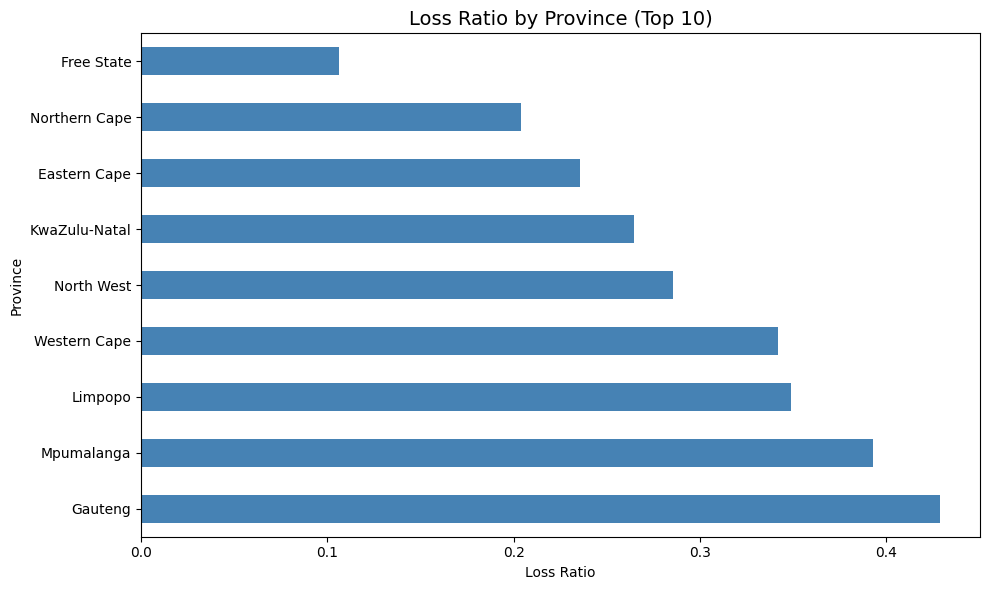

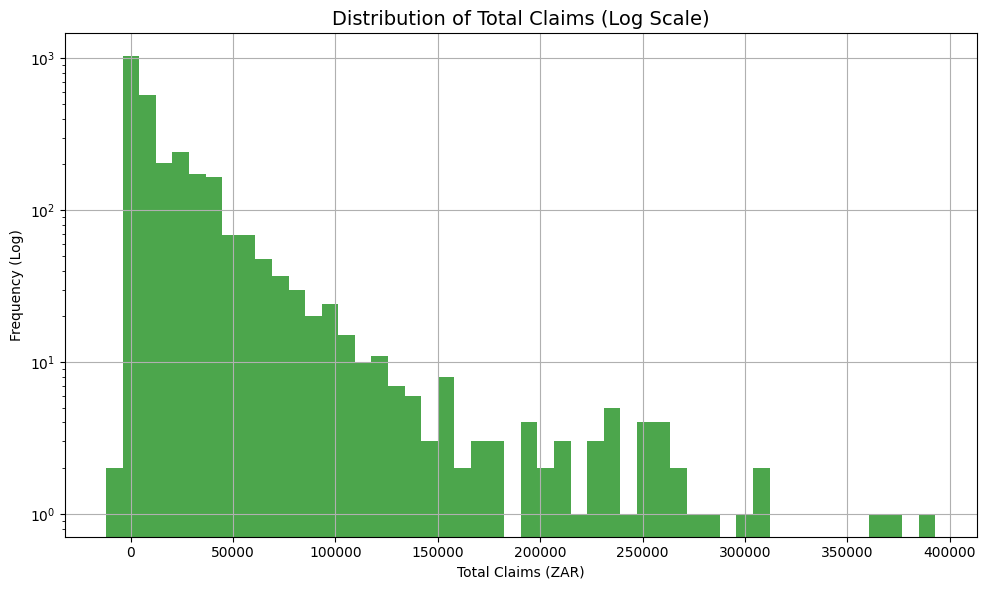

Skipping 'Average Claims by Vehicle Make': 'Make' or 'TotalClaims' column missing.


In [22]:
# Plot 1: Loss Ratio by Province (with safety checks)
try:
    if 'lr_by_province' not in globals():
        if 'Province' in df.columns and 'LossRatio' in df.columns:
            lr_by_province = df.groupby('Province')['LossRatio'].mean().sort_values(ascending=False)
        else:
            lr_by_province = None
    if lr_by_province is not None and not lr_by_province.empty:
        plt.figure(figsize=(10, 6))
        lr_by_province.head(10).plot(kind='barh', color='steelblue')
        plt.title('Loss Ratio by Province (Top 10)', fontsize=14)
        plt.xlabel('Loss Ratio')
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping 'Loss Ratio by Province' plot: no data available.")
except Exception as e:
    print(f"Error plotting Loss Ratio by Province: {e}")

# Plot 2: TotalClaims Distribution (log scale) - ensure numeric data
try:
    if 'TotalClaims' in df.columns:
        claims = pd.to_numeric(df['TotalClaims'], errors='coerce').replace(0, np.nan).dropna()
        if not claims.empty:
            plt.figure(figsize=(10, 6))
            claims.hist(bins=50, log=True, color='green', alpha=0.7)
            plt.title('Distribution of Total Claims (Log Scale)', fontsize=14)
            plt.xlabel('Total Claims (ZAR)')
            plt.ylabel('Frequency (Log)')
            plt.tight_layout()
            plt.show()
        else:
            print("Skipping 'TotalClaims' distribution: no numeric claim values available.")
    else:
        print("Skipping 'TotalClaims' distribution: column not found.")
except Exception as e:
    print(f"Error plotting TotalClaims distribution: {e}")

# Plot 3: Average Claims by Vehicle Make - check 'Make' exists
try:
    if 'Make' in df.columns and 'TotalClaims' in df.columns:
        top_makes = df['Make'].value_counts().head(10).index
        if len(top_makes) > 0:
            claim_by_make = df[df['Make'].isin(top_makes)].groupby('Make')['TotalClaims'].mean().sort_values(ascending=False)
            if not claim_by_make.empty:
                plt.figure(figsize=(10, 6))
                claim_by_make.plot(kind='bar', color='crimson')
                plt.title('Average Total Claims by Vehicle Make (Top 10)', fontsize=14)
                plt.ylabel('Avg Claim Amount (ZAR)')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
            else:
                print("Skipping 'Average Claims by Vehicle Make': no aggregated data.")
        else:
            print("Skipping 'Average Claims by Vehicle Make': no makes found.")
    else:
        print("Skipping 'Average Claims by Vehicle Make': 'Make' or 'TotalClaims' column missing.")
except Exception as e:
    print(f"Error plotting Average Claims by Vehicle Make: {e}")

In [6]:
# Export cleaned data (write to repository data folder)
out_path = '../data/insurance_data_clean.csv'
df.to_csv(out_path, index=False)
print(f"✅ Cleaned data saved to {out_path}")

✅ Cleaned data saved to ../data/insurance_data_clean.csv
